# Классификация сарказма

В данном ноутбуке мы разберем классический случай NLP - задача классификации.

In [2]:
from typing import Dict
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import re, string
from sklearn.metrics import confusion_matrix
import os
import warnings
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from catboost import CatBoostClassifier
from sklearn.metrics import (
    precision_recall_fscore_support,
    f1_score,
    recall_score,
    accuracy_score,
    precision_score,
    roc_auc_score,
    confusion_matrix,
    log_loss,
)
import optuna
from optuna.trial import Trial
import sklearn
from sklearn.linear_model import LogisticRegression
import mlflow
from dotenv import load_dotenv

import src.utils as p

warnings.filterwarnings("ignore")
np.random.seed(42)

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>
[nltk_data] Error loading wordnet: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


Для начала имортируем данные

In [4]:
df = pd.read_json('/Users/monty42/Projects/MLE_S2W1_mlflow/data/Sarcasm_Headlines_Dataset_v2.json', lines=True)

In [5]:
df.head()

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


Удалим лишние значения

In [6]:
df.drop(columns='article_link', inplace=True)
df.rename(columns={'headline': 'text'}, inplace=True)

In [7]:
df.head()

,is_sarcastic,text
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [6]:
# На случай важных переговоров
# Если у вас не скачаны стоп слова
import nltk
import ssl
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [8]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [9]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['text']=df['text'].apply(denoise_text)

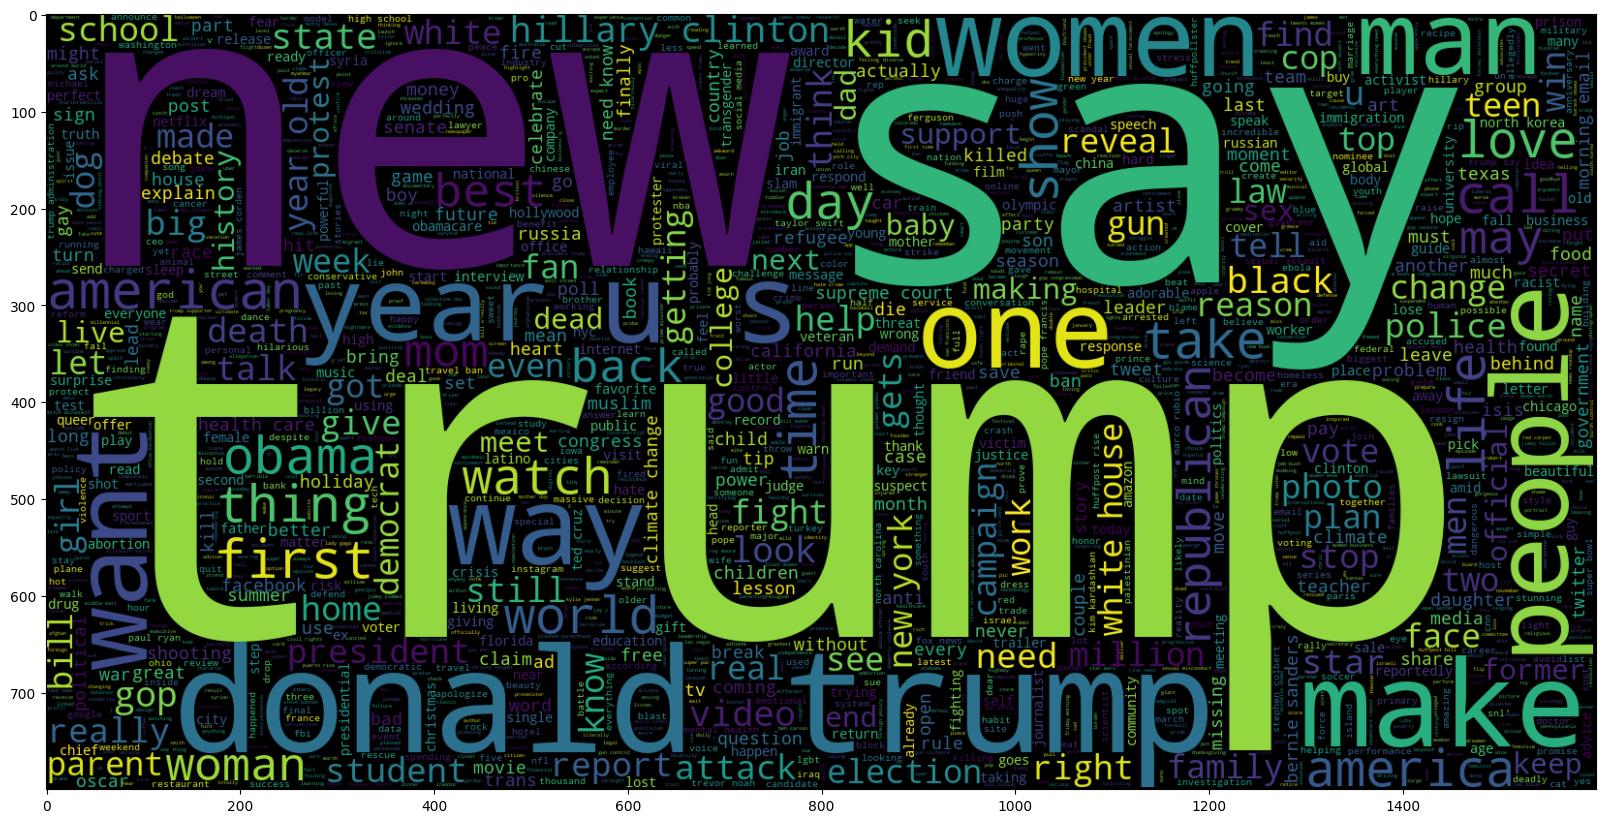

In [10]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].text))
plt.imshow(wc, interpolation='bilinear')

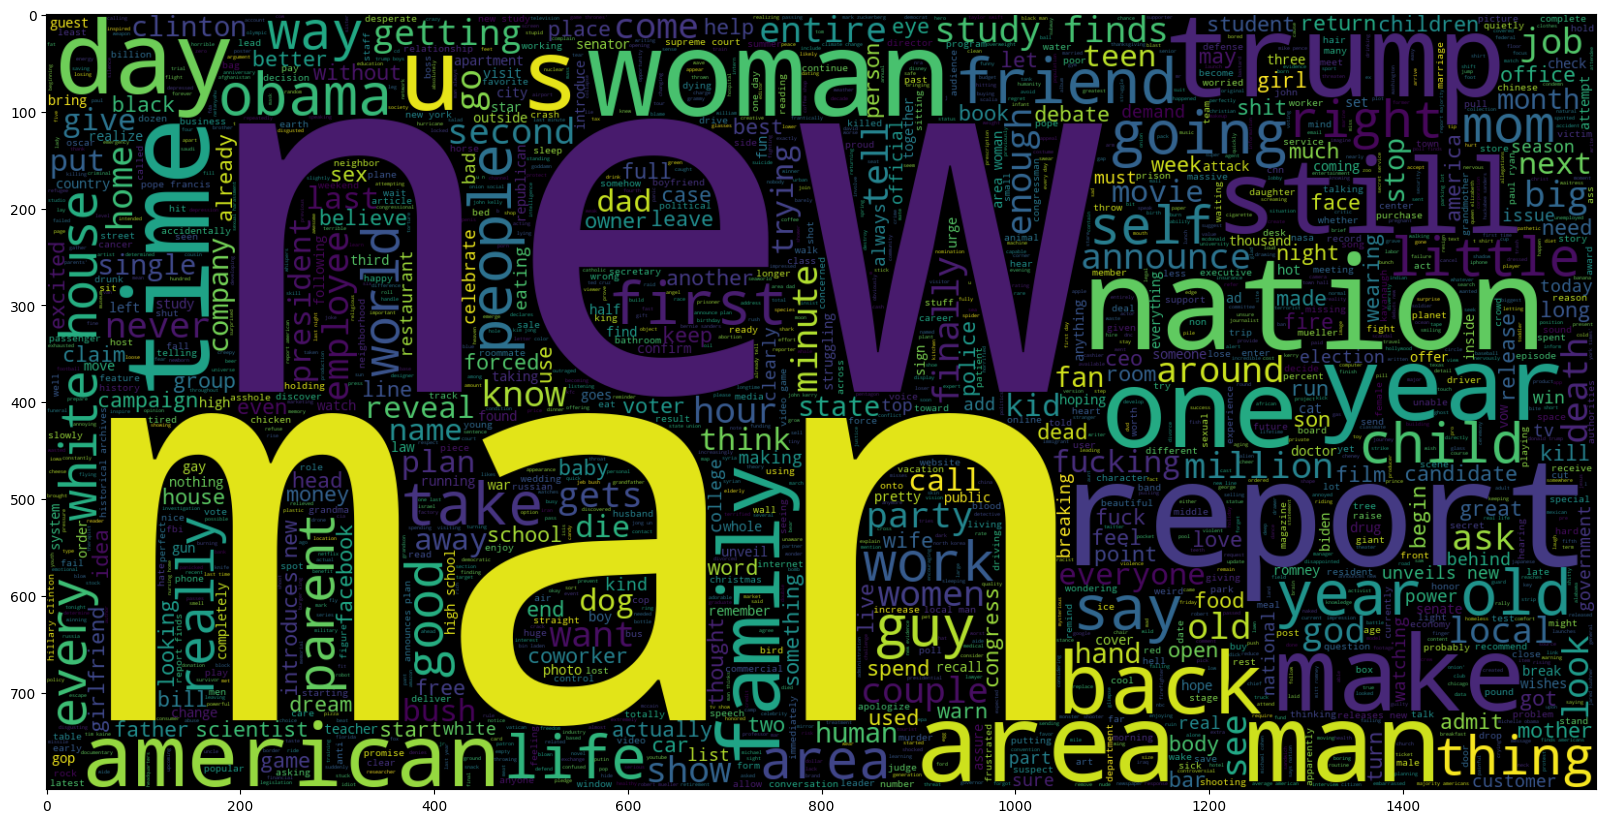

In [11]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

## Давайте обучим модель с помощью сервиса MLFlow

### Классический ML пайплайн

Обучим обычный TF-iDF векторайзер, а также градиентный бустинг

In [7]:
# Зададим переменные для MLFlow

EXPERIMENT_NAME = "churn_S2W2"
RUN_NAME = "model_sarcasm_classic"
REGISTRY_MODEL_NAME = "churn_model_sarcasm"

load_dotenv()
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_BUCKET_NAME"] = str(os.environ.get('S3_BUCKET_NAME'))
os.environ["AWS_ACCESS_KEY_ID"] = str(os.environ.get('AWS_ACCESS_KEY_ID'))
os.environ["AWS_SECRET_ACCESS_KEY"] = str(os.environ.get('AWS_SECRET_ACCESS_KEY'))
mlflow.set_tracking_uri(f"http://{os.environ.get('MLFLOW_SERVER_HOST')}:{os.environ.get('MLFLOW_SERVER_PORT')}")
mlflow.set_registry_uri(f"http://{os.environ.get('MLFLOW_SERVER_HOST')}:{os.environ.get('MLFLOW_SERVER_PORT')}")

if mlflow.get_experiment_by_name(name=EXPERIMENT_NAME):
    experiment_id = dict(mlflow.get_experiment_by_name(name=EXPERIMENT_NAME))['experiment_id']
    mlflow.set_experiment(experiment_id=experiment_id)
else:
    mlflow.set_experiment(EXPERIMENT_NAME)
    experiment_id = dict(mlflow.get_experiment_by_name(name=EXPERIMENT_NAME))['experiment_id']
    mlflow.set_experiment(experiment_id=experiment_id)

In [13]:
params = {
    'vect': {
        'ngram_range': (1, 2),
        'max_df': 0.95,
        'min_df': 2
    },
    'model': {
        
    }
}

In [ ]:
mlflow.sklearn.lo

### Модель 1

In [21]:
# Preprocess data
import src.utils as utils
wc1, wc2 = utils.create_cloud(df)
mlflow.log_image(wc1.to_image(), "non_sarcastic_cloud.png")
mlflow.log_image(wc2.to_image(), "sarcastic_cloud.png")

vector = TfidfVectorizer(**params['vect'])
X = vector.fit_transform(df['text'])
# Split the data into training and test sets. (0.8, 0.20) split.
X_train, X_test,  y_train, y_test = train_test_split(X, df['is_sarcastic'], test_size=0.2)

pip_requirements="./requirements.txt" 
signature = mlflow.models.infer_signature(X_test, y_test)
input_example = X_test[:10]
metadata = {"model_type": "daily"}

with mlflow.start_run(run_name=RUN_NAME+"_CatBoost", experiment_id=experiment_id, nested=True): # ['experiment_id']
    model = CatBoostClassifier(**params['model'])
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    _, err1, err2, _ = confusion_matrix(y_test, y_pred, normalize='all').ravel()
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    model_info = mlflow.catboost.log_model(
        cb_model=model,
        artifact_path="via_models",
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        await_registration_for=60,
        pip_requirements=pip_requirements,
        metadata=metadata,
    )

    mlflow.log_params(params=params)
    mlflow.log_metric("precision", precision[1])
    mlflow.log_metric("recall", recall[1])
    mlflow.log_metric("f_score", f_score[1])
    mlflow.log_metric("logloss", logloss)
    mlflow.log_metric("err1", err1)
    mlflow.log_metric("err2", err2)
    mlflow.log_metric("auc", auc)

Learning rate set to 0.039223
0:	learn: 0.6894974	total: 90.7ms	remaining: 1m 30s
1:	learn: 0.6851101	total: 114ms	remaining: 56.7s
2:	learn: 0.6820959	total: 136ms	remaining: 45.2s
3:	learn: 0.6793119	total: 158ms	remaining: 39.2s
4:	learn: 0.6759001	total: 181ms	remaining: 36s
5:	learn: 0.6730552	total: 202ms	remaining: 33.4s
6:	learn: 0.6705200	total: 223ms	remaining: 31.7s
7:	learn: 0.6682565	total: 245ms	remaining: 30.3s
8:	learn: 0.6662853	total: 266ms	remaining: 29.3s
9:	learn: 0.6639940	total: 287ms	remaining: 28.4s
10:	learn: 0.6622312	total: 309ms	remaining: 27.8s
11:	learn: 0.6607332	total: 331ms	remaining: 27.3s
12:	learn: 0.6588896	total: 353ms	remaining: 26.8s
13:	learn: 0.6575526	total: 375ms	remaining: 26.4s
14:	learn: 0.6562113	total: 397ms	remaining: 26.1s
15:	learn: 0.6542834	total: 418ms	remaining: 25.7s
16:	learn: 0.6531165	total: 439ms	remaining: 25.4s
17:	learn: 0.6521663	total: 461ms	remaining: 25.2s
18:	learn: 0.6512308	total: 482ms	remaining: 24.9s
19:	learn: 

Registered model 'churn_model_sarcasm' already exists. Creating a new version of this model...
2024/07/02 16:54:49 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_sarcasm, version 5
Created version '5' of model 'churn_model_sarcasm'.


### Модель 2

In [22]:
# Preprocess data
import src.utils as utils
wc1, wc2 = utils.create_cloud(df)
mlflow.log_image(wc1.to_image(), "non_sarcastic_cloud.png")
mlflow.log_image(wc2.to_image(), "sarcastic_cloud.png")

# Split the data into training and test sets. (0.8, 0.20) split.
X_train, X_test,  y_train, y_test = train_test_split(df.drop(columns='is_sarcastic'), df['is_sarcastic'], test_size=0.2)

pip_requirements="./requirements.txt" 
signature = mlflow.models.infer_signature(X_test, y_test)
input_example = X_test[:10]
metadata = {"model_type": "daily"}

with mlflow.start_run(run_name=RUN_NAME+"_Sklearn", experiment_id=experiment_id, nested=True): # ['experiment_id']
    ct = ColumnTransformer([('vect', TfidfVectorizer(**params['vect']), 'text')])
    model = Pipeline(
        [
            ('transformer', ct),
            ('model', CatBoostClassifier(**params['model']))
        ]
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    precision, recall, f_score, _ = precision_recall_fscore_support(y_test, y_pred)
    logloss = log_loss(y_test, y_pred)
    _, err1, err2, _ = confusion_matrix(y_test, y_pred, normalize='all').ravel()
    auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="via_models",
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME,
        await_registration_for=60,
        pip_requirements=pip_requirements,
        metadata=metadata,
    )

    mlflow.log_params(params=params)
    mlflow.log_metric("precision", precision[1])
    mlflow.log_metric("recall", recall[1])
    mlflow.log_metric("f_score", f_score[1])
    mlflow.log_metric("logloss", logloss)
    mlflow.log_metric("err1", err1)
    mlflow.log_metric("err2", err2)
    mlflow.log_metric("auc", auc)

Learning rate set to 0.039223
0:	learn: 0.6893492	total: 24.3ms	remaining: 24.3s
1:	learn: 0.6857678	total: 44.5ms	remaining: 22.2s
2:	learn: 0.6824569	total: 64.4ms	remaining: 21.4s
3:	learn: 0.6793344	total: 84.7ms	remaining: 21.1s
4:	learn: 0.6760313	total: 104ms	remaining: 20.8s
5:	learn: 0.6740204	total: 125ms	remaining: 20.6s
6:	learn: 0.6714306	total: 145ms	remaining: 20.5s
7:	learn: 0.6686923	total: 165ms	remaining: 20.4s
8:	learn: 0.6657906	total: 185ms	remaining: 20.3s
9:	learn: 0.6637195	total: 204ms	remaining: 20.2s
10:	learn: 0.6613331	total: 224ms	remaining: 20.1s
11:	learn: 0.6596686	total: 244ms	remaining: 20.1s
12:	learn: 0.6581417	total: 264ms	remaining: 20s
13:	learn: 0.6562347	total: 283ms	remaining: 20s
14:	learn: 0.6551454	total: 303ms	remaining: 19.9s
15:	learn: 0.6539837	total: 323ms	remaining: 19.9s
16:	learn: 0.6524673	total: 343ms	remaining: 19.8s
17:	learn: 0.6514937	total: 363ms	remaining: 19.8s
18:	learn: 0.6504453	total: 391ms	remaining: 20.2s
19:	learn: 

Registered model 'churn_model_sarcasm' already exists. Creating a new version of this model...
2024/07/02 16:56:22 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: churn_model_sarcasm, version 6
Created version '6' of model 'churn_model_sarcasm'.


### Оптимизация гиперпараметров

In [ ]:
# Зададим переменные для MLFlow

EXPERIMENT_NAME = "churn_S2W2"
RUN_NAME = "model_sarcasm_classic"
REGISTRY_MODEL_NAME = "churn_model_sarcasm"

load_dotenv()
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_BUCKET_NAME"] = str(os.environ.get('S3_BUCKET_NAME'))
os.environ["AWS_ACCESS_KEY_ID"] = str(os.environ.get('AWS_ACCESS_KEY_ID'))
os.environ["AWS_SECRET_ACCESS_KEY"] = str(os.environ.get('AWS_SECRET_ACCESS_KEY'))
mlflow.set_tracking_uri(f"http://{os.environ.get('MLFLOW_SERVER_HOST')}:{os.environ.get('MLFLOW_SERVER_PORT')}")
mlflow.set_registry_uri(f"http://{os.environ.get('MLFLOW_SERVER_HOST')}:{os.environ.get('MLFLOW_SERVER_PORT')}")

if mlflow.get_experiment_by_name(name=EXPERIMENT_NAME):
    experiment_id = dict(mlflow.get_experiment_by_name(name=EXPERIMENT_NAME))['experiment_id']
else:
    mlflow.set_experiment(EXPERIMENT_NAME)
    experiment_id = dict(mlflow.get_experiment_by_name(name=EXPERIMENT_NAME))['experiment_id']

In [29]:
def get_vect_trial(trial: Trial, vect_type: str) -> Dict:
    # logging.info('Get vectorizetion parameters - Start')
    if vect_type == 'count_vect':
        vect_params = {
            'type': "count_vect",
            "ngram_range": trial.suggest_categorical('count_vect.ngram_range', 
                                                     [(1, 1), (1, 2)]),
            "min_df": trial.suggest_int('count_vect.min_df', 1, 5),
            "max_df": trial.suggest_float('count_vect.max_df', 0.7, 0.95)                                      
        }
    elif vect_type == 'tfidf':
        vect_params = {
            'type': "tfidf",
            "ngram_range": trial.suggest_categorical('tfidf_vect.ngram_range', 
                                                     [(1, 1), (1, 2)]),
            "min_df": trial.suggest_int('tfidf_vect.min_df', 1, 5),
            "max_df": trial.suggest_float('tfidf_vect.max_df', 0.7, 0.95),
            "sublinear_tf": trial.suggest_categorical('tfidf_vect.sublinear_tf',
                                                      [True, False])                                    
        }
    # logging.info('Get vectorizetion parameters - End')
    return vect_params

def get_trial_params(trial: Trial) -> Dict:
    # logging.info('Get full trial parameters - Start')
    vect_space = trial.suggest_categorical('vectorizer_type',
                                           ['count_vect', 'tfidf'])
    vect_params = get_vect_trial(trial=trial, vect_type=vect_space)

    model_space = trial.suggest_categorical('classifier_type',
                                            ['catboost', 'logreg'])
    if model_space == 'catboost':
        model_params = {
            'type': 'catboost',
            'max_depth': trial.suggest_int('catboost.max_depth', 2, 5),
            'n_estimators': trial.suggest_int('catboost.n_estimators', 50, 300),
            'learning_rate': trial.suggest_float('catboost.learning_rate', 0.001, 1),
            'reg_lambda': trial.suggest_float('catboost.learning_rate', 0.001, 1),
            'auto_class_weights': trial.suggest_categorical('catboost.auto_class_weights',
                                                            ['Balanced', None]),
        }
    elif model_space == 'logreg':
        model_params = {
            'type': 'logreg',
            'class_weight': trial.suggest_categorical('logreg.class_weight',
                                                      ['balanced', None]),
            'penalty': trial.suggest_categorical('logreg.penalty',
                                                 ['l1', 'l2', None]),
            'C': trial.suggest_float('logreg.C', 0.1, 100)
        }
    
    full_space = {
        'vect': vect_params,
        'model': model_params
    }
    # logging.info('Get full trial parameters - End')
    return full_space

def get_optuna_pipeline(space: Dict):
    # logging.info('Get optuna pipeline - Start')
    vect_type = space['vect']['type']
    model_type = space['model']['type']
    del space['model']['type'], space['vect']['type']

    if vect_type == 'count_vect':
        vect = CountVectorizer(**space['vect'])
    elif vect_type == 'tfidf':
        vect = TfidfVectorizer(**space['vect'])
    else:
        logging.info(f"Don't match vect_type == {vect_type}")

    if model_type == 'catboost':
        model = CatBoostClassifier(**space['model'], verbose=False)
    elif model_type == 'logreg':
        solver = 'lbfgs'
        if space['model']['penalty'] == 'l1':
            solver = 'saga'
        model = LogisticRegression(**space['model'], solver=solver, random_state=42)
    else:
        logging.info(f"Don't match model_type == {model_type}")

    # logging.info('Get optuna pipeline - End')
    return build_pipeline(vect, model)

def build_pipeline(vect, model):
    # logging.info('Build Pipeline - Start')
    pipe = Pipeline(
        [
            ('vect', vect),
            ('model', model)
        ]
    )
    # logging.info('Build Pipeline - End')
    return pipe

def collect_optuna_metrics(trial: Trial):
    # logging.info(f'Start collect metrics trial {trial.number}')
    with mlflow.start_run(run_name=RUN_NAME+"_optuna_"+str(trial.number), nested=True):
        df = get_optuna_data()
        X = df['text']
        y = df['is_sarcastic']
        full_space = get_trial_params(trial=trial)
        pipeline = get_optuna_pipeline(full_space.copy())
        cv = StratifiedKFold(n_splits=5)
        cv_f1_macro = []
        cv_f1_micro = []
        cv_accuracy = []
        cv_logloss = []
        cv_f1_1_score = []
        cv_precision_1_score = []
        cv_recall_1_score = []
        overfit_penalty = []
        for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
            X_train = X[train_idx]
            y_train = y[train_idx]
            X_test = X[test_idx]
            y_test = y[test_idx]
            pipeline.fit(X_train, y_train)
            predict = pipeline.predict(X_test)
            overfit_penalty.append(
                f1_score(y_true=y_train, y_pred=pipeline.predict(X_train), labels=[1]) -  f1_score(y_true=y_test, y_pred=predict, labels=[1])
            )
            cv_f1_macro.append(f1_score(y_true=y_test, y_pred=predict, average='macro'))
            cv_f1_micro.append(f1_score(y_true=y_test, y_pred=predict, average='micro'))
            cv_accuracy.append(accuracy_score(y_true=y_test, y_pred=predict))
            cv_logloss.append(log_loss(y_true=y_test, y_pred=predict))
            cv_f1_1_score.append(f1_score(y_true=y_test, y_pred=predict, labels=[1]))
            cv_precision_1_score.append(precision_score(y_true=y_test, y_pred=predict, labels=[1]))
            cv_recall_1_score.append(recall_score(y_true=y_test, y_pred=predict, labels=[1]))
        
        answer_info = {
            'overfit_penalty': np.mean(overfit_penalty),
            'cv_f1_macro': np.mean(cv_f1_macro),
            'cv_f1_micro': np.mean(cv_f1_micro),
            'cv_accuracy': np.mean(cv_accuracy),
            'cv_logloss': np.mean(cv_logloss),
            'cv_f1_1_score': np.mean(cv_f1_1_score),
            'cv_precision_1_score': np.mean(cv_precision_1_score),
            'cv_recall_1_score': np.mean(cv_recall_1_score),
            'status': optuna.trial.TrialState.COMPLETE
        }
        if np.mean(cv_accuracy) or np.mean(cv_accuracy) == 1.0 or np.mean(overfit_penalty) > 0.3:
            answer_info.update({'status': optuna.trial.TrialState.FAIL})
        mlflow.log_params(full_space)
        mlflow.log_metrics(answer_info)
        # trial.set_user_attr('report', answer_info)
        # logging.info(f'End collect metrics trial {trial.number}')
    return np.mean(cv_f1_1_score)

def optuna_objective(trial: Trial, X, y):
    full_space = get_trial_params(trial=trial)
    pipeline = get_optuna_pipeline(full_space)
    return collect_optuna_metrics(pipeline=pipeline, trial=trial, X=X, y=y, full_space=full_space)

def get_optuna_data():
    df = pd.read_json('./data/Sarcasm_Headlines_Dataset_v2.json', lines=True)
    df.drop(columns='article_link', inplace=True)
    df.rename(columns={'headline': 'text'}, inplace=True)
    stop = set(stopwords.words('english'))
    punctuation = list(string.punctuation)
    stop.update(punctuation)
    def strip_html(text):
        soup = BeautifulSoup(text, "html.parser")
        return soup.get_text()

    #Removing the square brackets
    def remove_between_square_brackets(text):
        return re.sub('\[[^]]*\]', '', text)
    # Removing URL's
    def remove_between_square_brackets(text):
        return re.sub(r'http\S+', '', text)
    #Removing the stopwords from text
    def remove_stopwords(text):
        final_text = []
        for i in text.split():
            if i.strip().lower() not in stop:
                final_text.append(i.strip())
        return " ".join(final_text)
    #Removing the noisy text
    def denoise_text(text):
        text = strip_html(text)
        text = remove_between_square_brackets(text)
        text = remove_stopwords(text)
        return text
    #Apply function on review column
    df['text']=df['text'].apply(denoise_text)
    return df

def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [32]:
df = get_optuna_data()
X = df['text']
y = df['is_sarcastic']

pip_requirements="./requirements.txt" 
signature = mlflow.models.infer_signature(df)
input_example = df[:10]
metadata = {"model_type": "daily"}

In [34]:
with mlflow.start_run(experiment_id=experiment_id, run_name=RUN_NAME+"_optuna"):
    study = optuna.create_study(direction='maximize')
    study.optimize(collect_optuna_metrics, n_trials=10, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_precision", study.best_value)

    mlflow.set_tags(
        tags={
            'project': EXPERIMENT_NAME,
            'engine': 'optuna',
            'version': 1
        }
    )
    def get_params_after_learning(params, key: str) -> Dict:
        _params = {}
        for _key in study.best_params.keys():
            if _key.startswith(key):
                _key = _key.replace(key, '')
                _params[_key] = params[key+_key]
        return _params

    if study.best_params['vectorizer_type'] == 'tfidf':
        vect_params = get_params_after_learning(study.best_params, 'tfidf_vect.')
        vect = TfidfVectorizer(**vect_params)
    else:
        vect_params = get_params_after_learning(study.best_params, 'count_vect.')
        vect = CountVectorizer(**vect_params)

    if study.best_params['classifier_type'] == 'logreg':
        model_params = get_params_after_learning(study.best_params, 'logreg.')
        model_params['solver'] = 'lbfgs'
        if model_params['penalty'] == 'l1':
            model_params['solver'] = ('saga')
        model = LogisticRegression(**model_params, random_state=42)
    else:
        model_params = get_params_after_learning(study.best_params, 'catboost.')
        model = CatBoostClassifier(**model_params)

    pipe = Pipeline(
        [
            ('vect', vect), 
            ('model', model)
        ]
    )
    pipe.fit(X=X, y=y)

    model_info = mlflow.sklearn.log_model(
        sk_model=model,
        artifact_path="via_models",
        signature=signature,
        input_example=input_example,
        registered_model_name=REGISTRY_MODEL_NAME+'_tune',
        await_registration_for=60,
        pip_requirements=pip_requirements,
        metadata=metadata,
    )

    mlflow.log_param('vect_type', study.best_params['vectorizer_type'])
    mlflow.log_params(vect_params)
    mlflow.log_param('model_type', study.best_params['classifier_type'])
    mlflow.log_params(model_params)
    

[I 2024-07-03 17:44:30,574] A new study created in memory with name: no-name-130fc986-5446-40e1-8794-b95b02f1ee0c
[I 2024-07-03 17:44:34,716] Trial 0 finished with value: 0.6277463245012946 and parameters: {'vectorizer_type': 'tfidf', 'tfidf_vect.ngram_range': (1, 1), 'tfidf_vect.min_df': 4, 'tfidf_vect.max_df': 0.7307329507090085, 'tfidf_vect.sublinear_tf': True, 'classifier_type': 'catboost', 'catboost.max_depth': 3, 'catboost.n_estimators': 72, 'catboost.learning_rate': 0.9651177902989743, 'catboost.auto_class_weights': 'Balanced'}. Best is trial 0 with value: 0.6277463245012946.


Initial trial 0 achieved value: 0.6277463245012946


[I 2024-07-03 17:44:41,553] Trial 1 finished with value: 0.7174185475140306 and parameters: {'vectorizer_type': 'count_vect', 'count_vect.ngram_range': (1, 2), 'count_vect.min_df': 5, 'count_vect.max_df': 0.8852590708320844, 'classifier_type': 'catboost', 'catboost.max_depth': 5, 'catboost.n_estimators': 169, 'catboost.learning_rate': 0.44980399413632227, 'catboost.auto_class_weights': None}. Best is trial 1 with value: 0.7174185475140306.


Trial 1 achieved value: 0.7174185475140306 with  12.4993% improvement


[I 2024-07-03 17:44:45,028] Trial 2 finished with value: 0.7629690194936446 and parameters: {'vectorizer_type': 'count_vect', 'count_vect.ngram_range': (1, 2), 'count_vect.min_df': 3, 'count_vect.max_df': 0.9069914306371956, 'classifier_type': 'logreg', 'logreg.class_weight': 'balanced', 'logreg.penalty': 'l2', 'logreg.C': 41.685282715708404}. Best is trial 2 with value: 0.7629690194936446.


Trial 2 achieved value: 0.7629690194936446 with  5.9702% improvement


[I 2024-07-03 17:44:47,908] Trial 3 finished with value: 0.7385603190586677 and parameters: {'vectorizer_type': 'tfidf', 'tfidf_vect.ngram_range': (1, 2), 'tfidf_vect.min_df': 4, 'tfidf_vect.max_df': 0.8144782840313444, 'tfidf_vect.sublinear_tf': False, 'classifier_type': 'logreg', 'logreg.class_weight': 'balanced', 'logreg.penalty': None, 'logreg.C': 36.05169853625388}. Best is trial 2 with value: 0.7629690194936446.
[I 2024-07-03 17:45:09,690] Trial 4 finished with value: 0.7329239000300155 and parameters: {'vectorizer_type': 'tfidf', 'tfidf_vect.ngram_range': (1, 2), 'tfidf_vect.min_df': 2, 'tfidf_vect.max_df': 0.9434395394927975, 'tfidf_vect.sublinear_tf': False, 'classifier_type': 'catboost', 'catboost.max_depth': 5, 'catboost.n_estimators': 256, 'catboost.learning_rate': 0.35041631614800584, 'catboost.auto_class_weights': 'Balanced'}. Best is trial 2 with value: 0.7629690194936446.
[I 2024-07-03 17:45:11,809] Trial 5 finished with value: 0.7435879530779615 and parameters: {'vecto